## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [6]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [5]:
theta_fiducial = np.array([0.1197, 0.76])


## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [7]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [8]:
N_countsSimulator = n_counts_simulator.Model()

In [9]:
N_countsSimulator.N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [10]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [11]:
N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

## Fisher contours

### Derivative (five-point stencil)

In [12]:
def compute_derivative(theta_fiducial, param_index, delta_param, log10masses = np.linspace(14, 15.5, num = 4),
                       z_min = np.linspace(0.1, 0.9, num = 5), z_max = np.linspace(0.2, 1.0, num = 5)):
    
    log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))
    
    theta_2h = theta_fiducial
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h)
    
    theta_h = theta_fiducial
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h)
    
    theta_h_neg = theta_fiducial
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_h_neg)
    
    
    theta_2h_neg = theta_fiducial
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_2h_neg)
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

### Covariance matrix

In [75]:
cov_matrix = np.diag(N_countsSimulator.N_counts)
cov_matrix_inv = np.linalg.inv(cov_matrix)

### $\Omega_{cdm}h^{2}$

In [77]:
deriv_omega_cdm = compute_derivative(theta_fiducial, 0, 0.01*theta_fiducial[0])
deriv_omega_cdm

array([ 1.19542296e+05,  3.34160972e+05,  3.92781454e+05,  3.22677524e+05,
        2.14730847e+05,  1.78626576e+04,  3.63557690e+04,  2.89597499e+04,
        1.50440546e+04,  5.89778242e+03,  8.19604307e+02,  8.84989444e+02,
        3.00220263e+02,  4.27195044e+01, -2.32983349e+00])

### $\sigma_{8}$

In [78]:
deriv_sigma8 = compute_derivative(theta_fiducial, 1, 0.01*theta_fiducial[1])
deriv_sigma8

array([3.40194173e+04, 1.39955773e+05, 2.38310053e+05, 2.75412993e+05,
       2.49371899e+05, 9.32360505e+03, 2.85133562e+04, 3.47060840e+04,
       2.76755917e+04, 1.67010453e+04, 9.01264951e+02, 1.70471588e+03,
       1.18476920e+03, 5.01005878e+02, 1.48811278e+02])

### Compute Fisher matrix

In [79]:
fisher_matrix = np.zeros((2, 2))
fisher_matrix 

array([[0., 0.],
       [0., 0.]])

#### (1) compute diagonals

In [80]:
fisher_matrix[0, 0] = np.dot(np.dot(deriv_omega_cdm.reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_omega_cdm)
fisher_matrix[0, 0]

7437007.9605880715

In [81]:
fisher_matrix[1, 1] = np.dot(np.dot(deriv_sigma8.reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_sigma8)
fisher_matrix[1, 1]

4205257.784624225

#### (2) compute off-diagonals

In [82]:
fisher_matrix[0, 1] = np.dot(np.dot(deriv_omega_cdm.reshape(1, 15), np.linalg.inv(cov_matrix)), deriv_sigma8)
fisher_matrix[1, 0] = fisher_matrix[0, 1]
fisher_matrix[1, 0]

5065853.844138862

#### (3) compute covariance matrix for the parameters

In [83]:
fisher_matrix

array([[7437007.96058807, 5065853.84413886],
       [5065853.84413886, 4205257.78462423]])

In [84]:
covariance_matrix = np.linalg.inv(fisher_matrix)
covariance_matrix 

array([[ 7.49378517e-07, -9.02737058e-07],
       [-9.02737058e-07,  1.32527761e-06]])

#### (4) make a triangle plot with fisher contours

In [85]:
import getdist
from getdist import plots, MCSamples
import matplotlib as mpl
from matplotlib.patches import Ellipse
from scipy.stats import norm

In [86]:
posterior_samples = np.loadtxt('simulators/mass_function_n_counts/results_tinker_2params_CMAFs_3000/posterior_samples.npy')
posterior_weights = np.loadtxt('simulators/mass_function_n_counts/results_tinker_2params_CMAFs_3000/posterior_weights.npy')

In [98]:
samples = [posterior_samples]
weights = [posterior_weights]
mc_samples = [MCSamples(samples=s, weights=weights[i], 
                        names=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'], 
                        labels=['\\Omega_{cdm}h^{2}', '\\sigma_{8}'],
                        ranges={'\\Omega_{cdm}h^{2}': [0.1125, 0.1275], '\\sigma_{8}': [0.6, 1.1]}) 
              for i, s in enumerate(samples)]

Removed no burn in


In [104]:
#theta_cdm = np.linspace(0.1184, 0.1216, 100)
theta_cdm = np.linspace(0.1125, 0.1275, 1000)
norm_theta_cdm = norm.pdf(theta_cdm, theta_fiducial[0], np.sqrt(covariance_matrix[0, 0]))/np.max(norm.pdf(theta_cdm, theta_fiducial[0], np.sqrt(covariance_matrix[0, 0])))

#theta_s8 = np.linspace(0.754, 0.764, 100)
theta_s8 = np.linspace(0.7, 0.8, 1000)
norm_theta_s8 = norm.pdf(theta_s8, theta_fiducial[1], np.sqrt(covariance_matrix[1, 1]))/np.max(norm.pdf(theta_s8, theta_fiducial[1], np.sqrt(covariance_matrix[1, 1])))


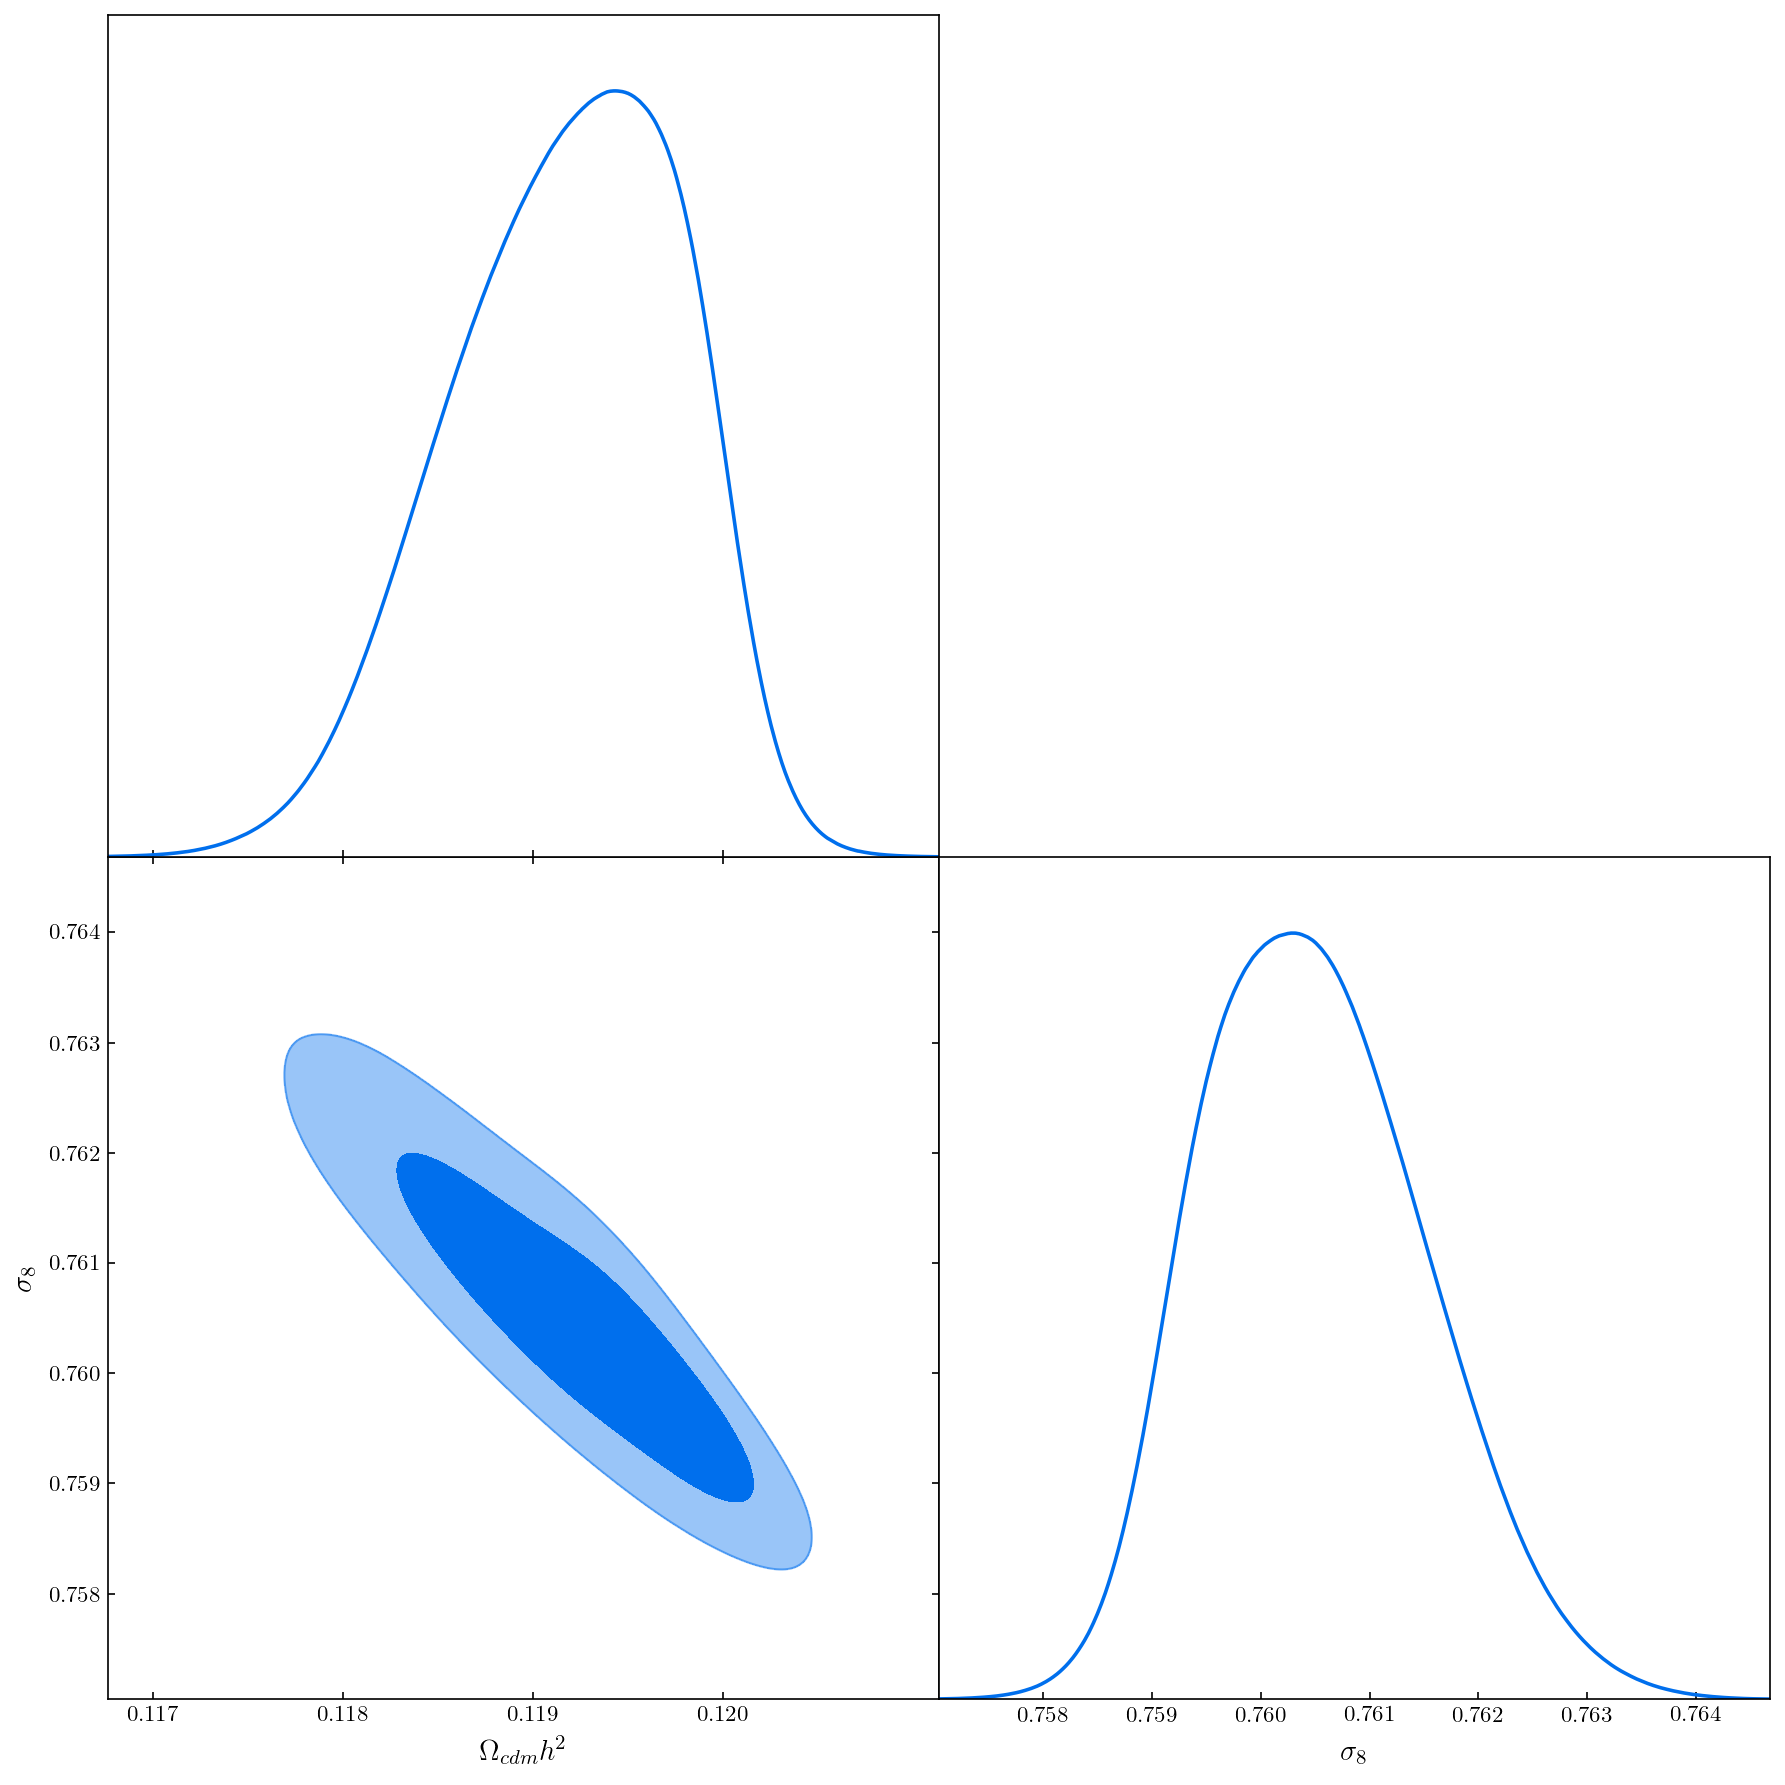

In [105]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(mc_samples, filled_compare=True, normalized=True)

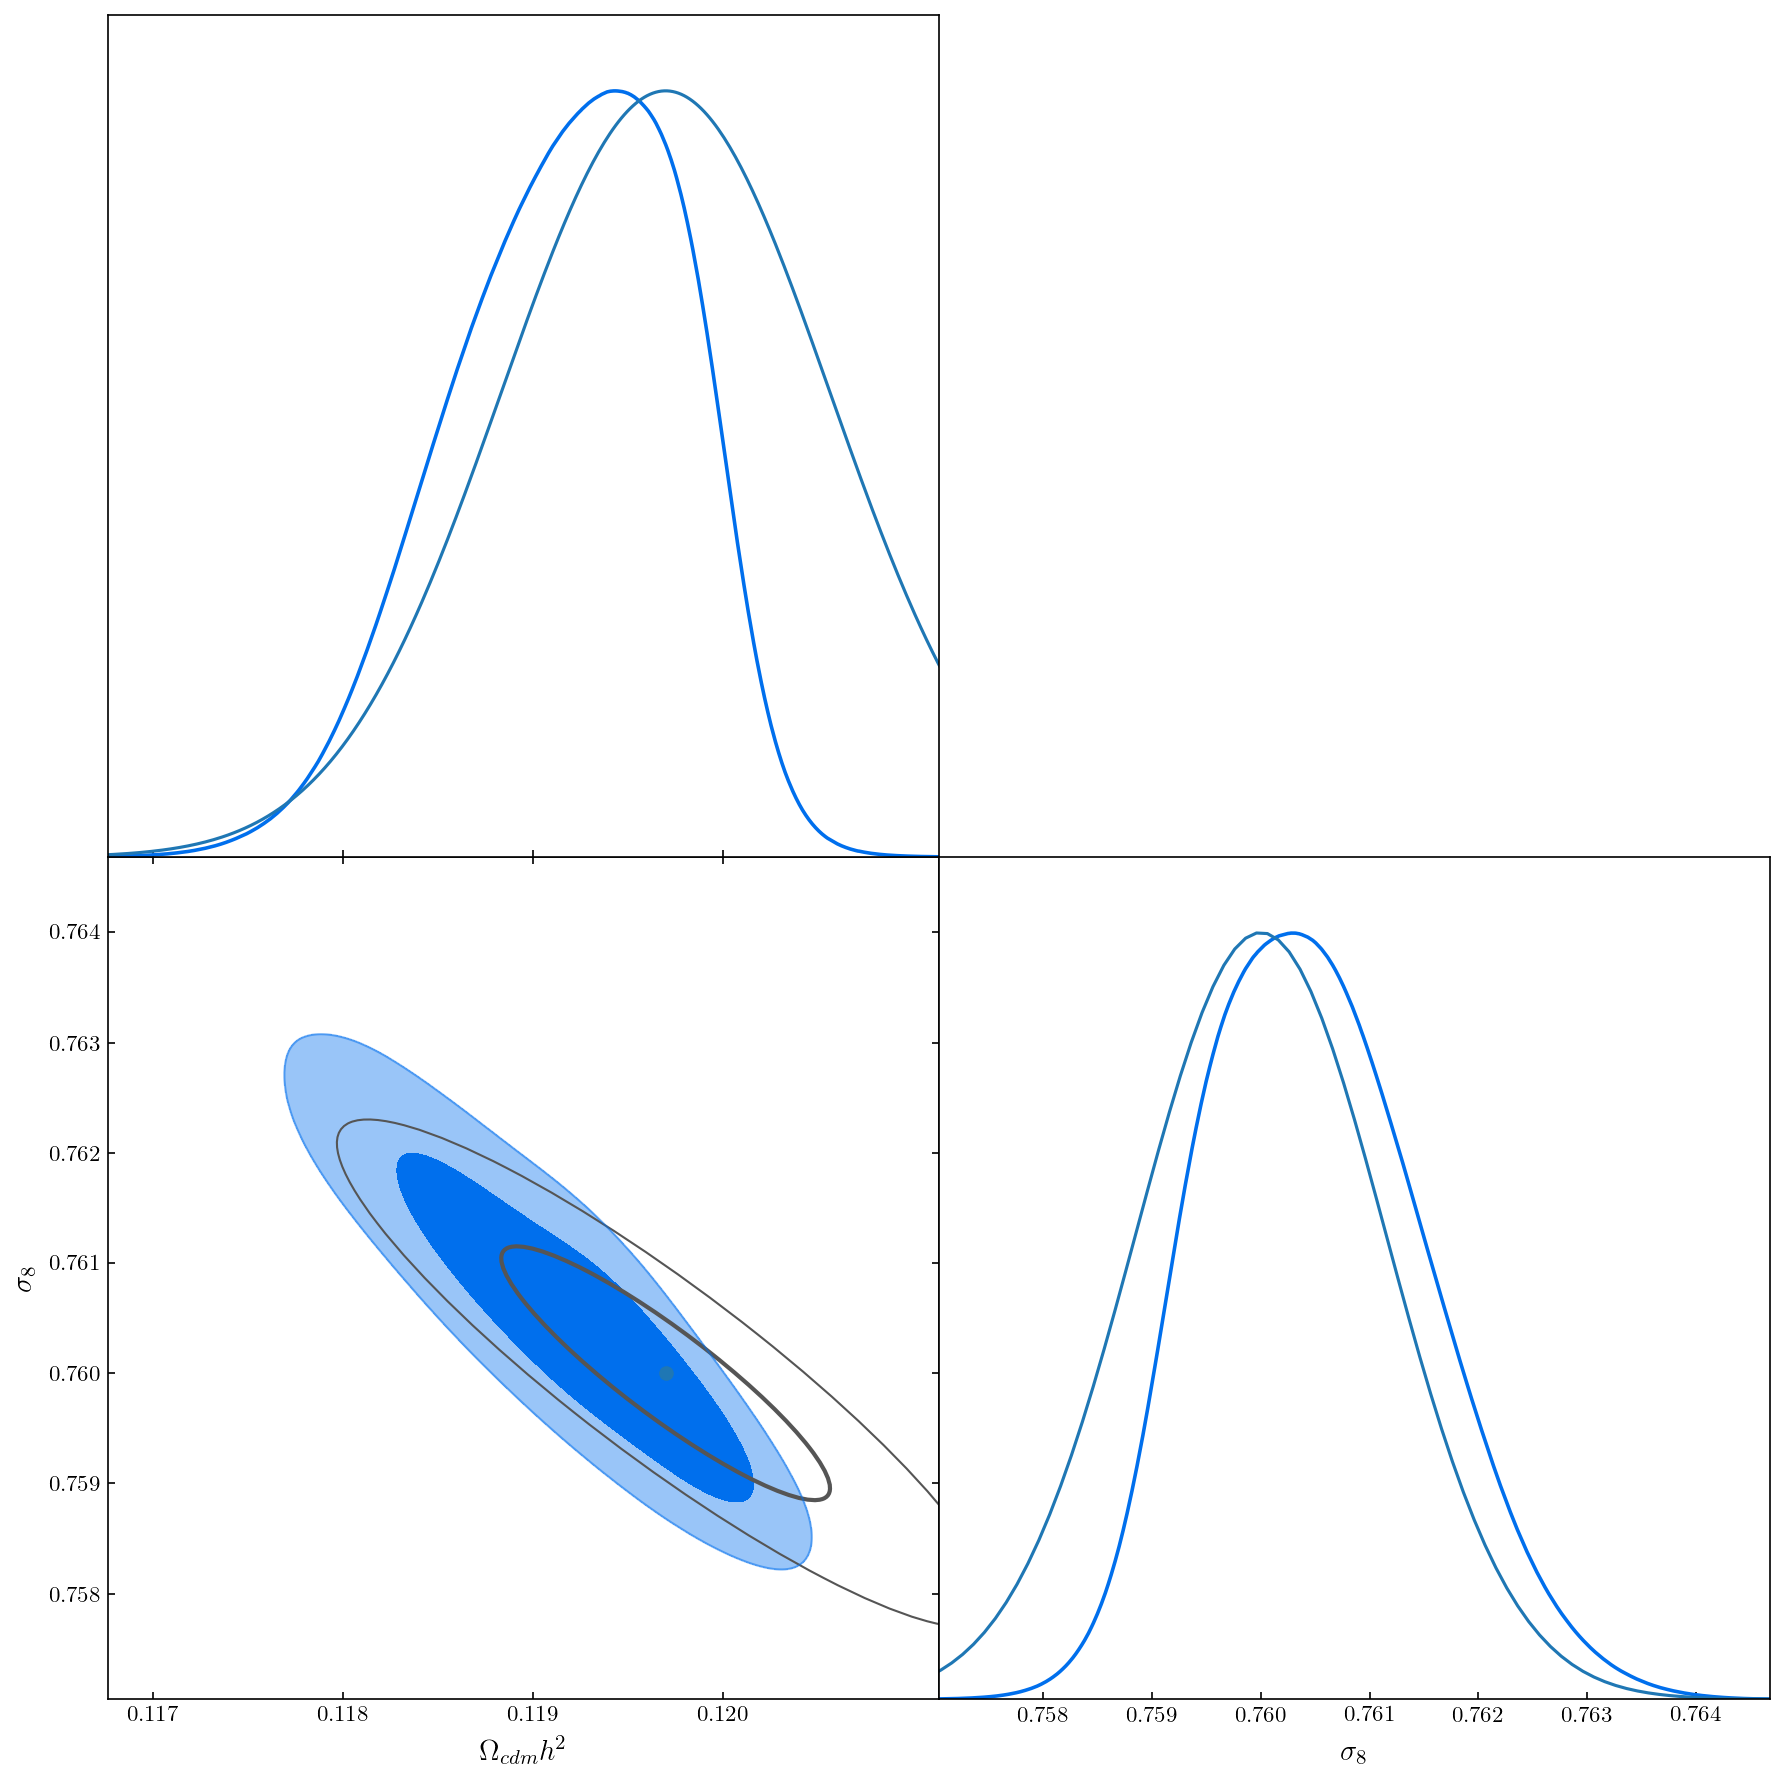

In [106]:
g = plots.getSubplotPlotter(width_inch = 12)
g.triangle_plot(mc_samples, filled_compare=True, normalized=True)
ax0 = g.subplots[0,0]
#ax.plot(theta_fiducial[0], theta_fiducial[0], marker='o', zorder=9, label='estimate')
ax0.plot(theta_cdm, norm_theta_cdm)
ax1 = g.subplots[1,1]
ax1.plot(theta_s8, norm_theta_s8)


ax01 = g.subplots[1,0]
ax01.plot(theta_fiducial[0], theta_fiducial[1], marker='o', zorder=9, label='estimate')
eigval,eigvec = np.linalg.eig(covariance_matrix[:2, :2])
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))
w,h = 2*np.sqrt(eigval)
for n in [1,2]:
    ax01.add_patch(Ellipse(theta_fiducial[:2], width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))


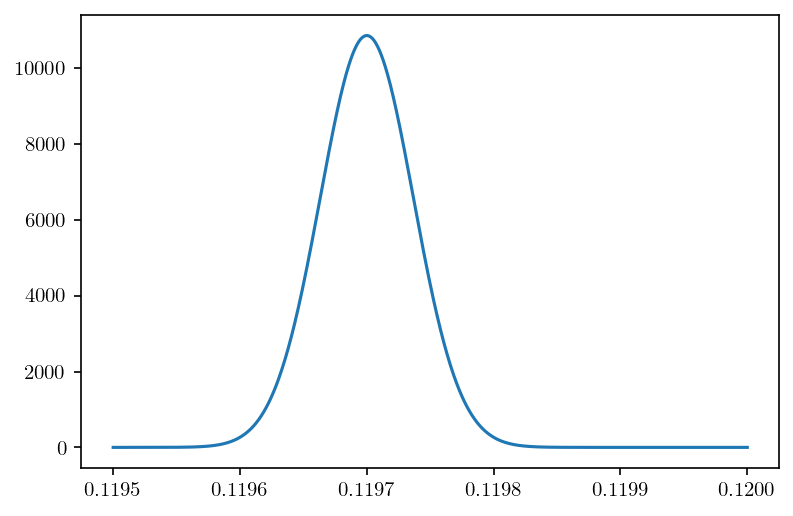

In [72]:
import matplotlib.pyplot as plt
theta_cdm_temp = np.linspace(0.1195, 0.1200, 1000)
plt.figure()
plt.plot(theta_cdm_temp, norm.pdf(theta_cdm_temp, theta_fiducial[0], np.sqrt(covariance_matrix[0, 0])))

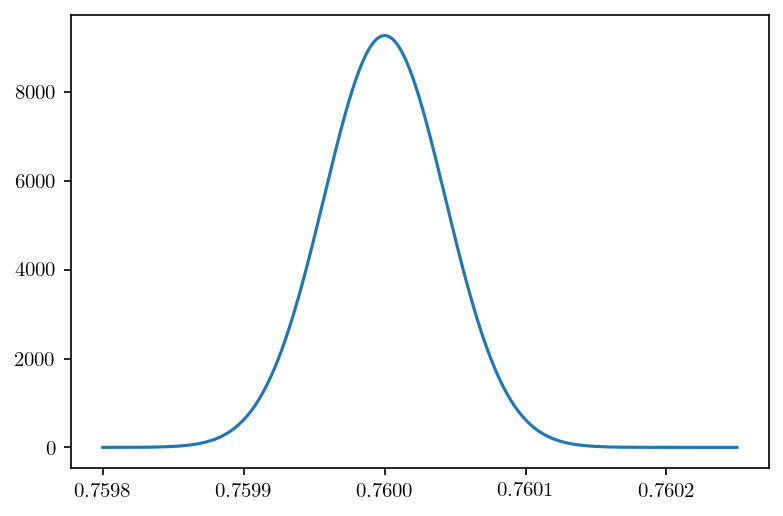

In [70]:
theta_s8_temp = np.linspace(0.7598, 0.76025, 1000)
plt.figure()
plt.plot(theta_s8_temp, norm.pdf(theta_s8_temp, theta_fiducial[1], np.sqrt(covariance_matrix[1, 1])))